In [1]:
# imports and setup 

import pandas as pd
import numpy as np

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
import math as mt

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

In [2]:
career = pd.read_csv('career_w_awards.csv',index_col=0)

In [3]:
rookie = pd.read_csv('rookie_w_awards.csv',index_col=0)

For the players who don't have information on games started, we will assume that they were starters if they played more than 22 minutes per game.

In [4]:
career['starter'] = np.where(career['MinPerGame']>=22, 1, 0)

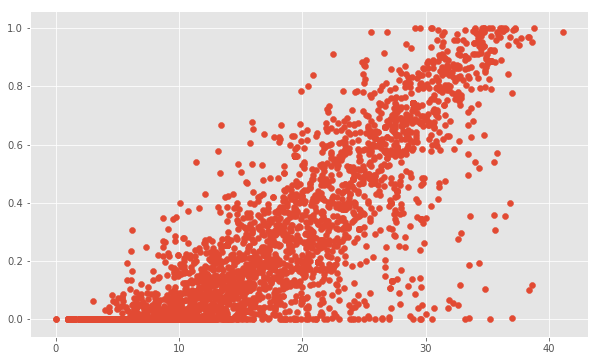

In [5]:
plt.scatter(x = career["MinPerGame"], y = career["Percent_Games_Started"])

In [6]:
career['MinPerGame'].median()

15.9

In [7]:
career['All_Star'] = np.where(career['All-Star Games'] >= 1, 1, 0)

In [8]:
career['MVP'] = np.where(career['MVPs'] >= 1, 1, 0)

In [9]:
career['Games Played_x'].median()

183.0

In [10]:
career['Role_Player'] = np.where(np.logical_and(career['MinPerGame']<22, career['Games Played_x']>=183), 1, 0)

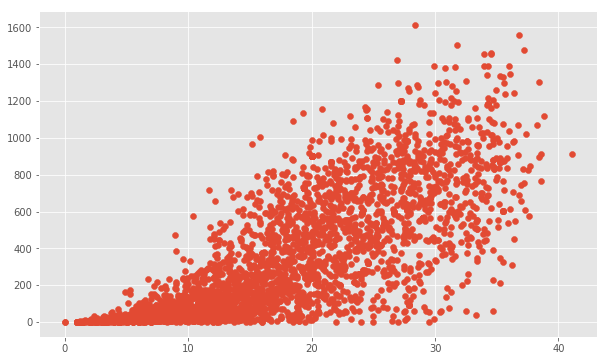

In [11]:
plt.scatter(x = career["MinPerGame"], y = career["Games Played_x"])

In [12]:
career['Bust'] = np.where(np.logical_and(career['Games Played_x'] < 183, career['MinPerGame']<22), 1, 0)

count = 0
for index, row in career.iterrows():
    if (mt.isnan(row['Percent_Games_Started']) and row['MVP'] == 0 and row['All_Star'] == 0):
        count+=1
        if row['MinPerGame'] >= 22:
            career.set_value(index,'starter',1)
        else:
            if row['Games Played_x'] >= 183:
                career.set_value(index,'Role_Player',1)
            else: career.set_value(index,'Bust',1)
print(count)

In [13]:
for index, row in career.iterrows():
    if row['Role_Player'] == 1:
        career.set_value(index,'target',4)
        if row['All_Star'] == 1:
            career.set_value(index,'target',2)
            if row['MVP'] == 1:
                career.set_value(index,'target',1)
    if row['Bust'] == 1:
        career.set_value(index,'target',5)
        if row['All_Star'] == 1:
            career.set_value(index,'target',2)
            if row['MVP'] == 1:
                career.set_value(index,'target',1)
    if row['starter'] == 1:
        career.set_value(index,'target',3)
        if row['All_Star'] == 1:
            career.set_value(index,'target',2)
            if row['MVP'] == 1:
                career.set_value(index,'target',1)



In [14]:
career[career['All_Star']==1]

,Name,Games Played_x,Games Started_x,MinPerGame,FGPerGame,FGAPerGame,FG%PerGame,3pPerGame,3PAPerGame,3p%PerGame,...,Percent_Games_Started,MVPs,All-Star Games,All-NBA Teams,starter,All_Star,MVP,Role_Player,Bust,target
0,A.C. Green,1278,832.0,28.6,3.6,7.2,0.494,0.1,0.4,0.254,...,0.651017,0,1,0,1,1,0,0,0,2.0
28,Adrian Dantley,955,546.0,35.8,8.6,15.8,0.540,0.0,0.1,0.171,...,0.571728,0,6,2,1,1,0,0,0,2.0
31,Al Horford,704,700.0,33.2,6.0,11.4,0.526,0.4,1.1,0.368,...,0.994318,0,5,1,1,1,0,0,0,2.0
57,Alex English,1193,753.0,31.9,8.9,17.6,0.507,0.0,0.1,0.217,...,0.631182,0,8,3,1,1,0,0,0,2.0
72,Allan Houston,839,727.0,33.7,6.4,14.3,0.444,1.6,3.9,0.402,...,0.866508,0,2,0,1,1,0,0,0,2.0
75,Allen Iverson,914,901.0,41.1,9.3,21.8,0.425,1.2,3.7,0.313,...,0.985777,0,11,7,1,1,0,0,0,2.0
80,Alonzo Mourning,838,686.0,31.0,6.1,11.6,0.527,0.0,0.1,0.247,...,0.818616,0,7,2,1,1,0,0,0,2.0
84,Alvan Adams,988,342.0,27.5,5.8,11.6,0.498,0.0,0.0,0.133,...,0.346154,0,1,0,1,1,0,0,0,2.0
87,Alvin Robertson,779,680.0,31.7,5.7,11.9,0.477,0.3,1.0,0.295,...,0.872914,0,4,1,1,1,0,0,0,2.0
92,Amar'e Stoudemire,846,696.0,31.0,7.0,13.0,0.537,0.0,0.2,0.236,...,0.822695,0,6,5,1,1,0,0,0,2.0


In [15]:
target = career[['target']]

In [16]:
target

,target
0,2.0
1,5.0
2,5.0
3,5.0
4,5.0
5,4.0
6,5.0
7,4.0
8,3.0
9,4.0


In [17]:
target[pd.isnull(target).any(axis=1)]

,target


In [18]:
rookie

,Name,Age_x,Position_x,Games Played_x,Games Started_x,MinPerGame,FGPerGame,FGAPerGame,FG%PerGame,3pPerGame,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Percent_Games_Started,All-Rookie Team,ROY
0,A.C. Green,22.0,PF,82,1.0,18.8,2.5,4.7,0.539,0.0,...,2.0,3.3,0.103,-0.5,0.8,0.3,0.9,0.012195,0,0
1,A.J. Bramlett,23.0,C,8,0.0,7.6,0.5,2.6,0.190,0.0,...,0.1,-0.2,-0.129,-10.5,-6.3,-16.8,-0.2,0.000000,0,0
2,A.J. English,23.0,SG,70,12.0,20.6,3.6,8.2,0.439,0.0,...,0.7,0.2,0.008,-2.5,-2.3,-4.8,-1.0,0.171429,0,0
3,A.J. Guyton,22.0,PG,33,8.0,19.1,2.4,5.8,0.406,0.8,...,-0.1,0.3,0.020,-1.5,-4.4,-5.9,-0.6,0.242424,0,0
4,A.J. Hammons,24.0,C,22,0.0,7.4,0.8,1.9,0.405,0.2,...,0.2,0.0,-0.001,-7.5,2.0,-5.6,-0.1,0.000000,0,0
5,A.J. Price,23.0,PG,56,2.0,15.4,2.6,6.3,0.410,1.1,...,0.8,1.2,0.065,0.2,-2.0,-1.8,0.0,0.035714,0,0
6,A.J. Wynder,26.0,PG,6,0.0,6.5,0.5,2.0,0.250,0.0,...,0.0,0.0,-0.051,-5.9,-3.5,-9.4,-0.1,0.000000,0,0
7,Aaron Brooks,23.0,PG,51,0.0,11.9,1.8,4.4,0.413,0.7,...,0.8,1.4,0.112,0.0,-1.8,-1.8,0.0,0.000000,0,0
8,Aaron Gordon,19.0,PF,47,8.0,17.0,2.0,4.4,0.447,0.3,...,0.7,1.0,0.060,-2.8,0.0,-2.8,-0.2,0.170213,0,0
9,Aaron Gray,23.0,C,61,1.0,10.0,1.7,3.3,0.505,0.0,...,0.8,0.8,0.066,-2.4,0.4,-2.0,0.0,0.016393,0,0


In [19]:
rookie1 = rookie.drop(['Name','Position_x'],axis=1)


In [20]:
rookie1 = rookie1.fillna(0)

In [115]:
X = scale(rookie1.values)
Y = target.values

In [134]:
XTrain, XTest, yTrain, yTest = train_test_split(X, Y, random_state=1,  test_size=0.8)

In [135]:
model = svm.SVC(kernel='rbf',C=2)
model.fit(XTrain, yTrain.ravel())
expected = yTest
predicted = model.predict(XTest)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = expected, y_pred = predicted))

print('Accuracy = ', metrics.accuracy_score(y_true = expected, y_pred = predicted))

Confusion Matrix:
[[   0    6    4    0    1]
 [   0  106  136   62   40]
 [   0   34  248  165  113]
 [   0   14   51  296  283]
 [   0    2   15  158 1251]]
Accuracy =  0.636850921273


In [121]:
np.where(predicted == 1)[0]

array([], dtype=int64)

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selec

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selec

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selec

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selec

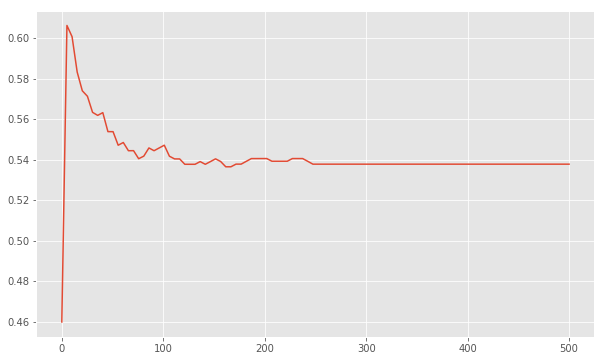

In [66]:
model.get_params()

Cs = np.linspace(.01,500,100)
Accuracies = np.zeros(Cs.shape[0])
for i,C in enumerate(Cs): 
    model = svm.SVC(kernel='rbf', C = C)
    scores = cross_val_score(estimator = model, X = XTrain, y = yTrain.ravel(), cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Cs,Accuracies)
plt.show()

In [102]:
clf = KNeighborsClassifier(n_neighbors=48)
clf.fit(XTrain, yTrain.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=48, p=2,
           weights='uniform')

In [103]:
print('Confusion Matrix:')
Expected = yTest
Prediction = clf.predict(XTest)
print(metrics.confusion_matrix(y_true = Expected, y_pred = Prediction))

print('Accuracy = ', metrics.accuracy_score(y_true = Expected, y_pred = Prediction))

Confusion Matrix:
[[   0    4    7    0    0]
 [   0   31  163  104   46]
 [   0    0  185  216  159]
 [   0    0   24  322  298]
 [   0    0    6  260 1160]]
Accuracy =  0.568844221106


C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_se

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_se

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_se

C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\z092205\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_se

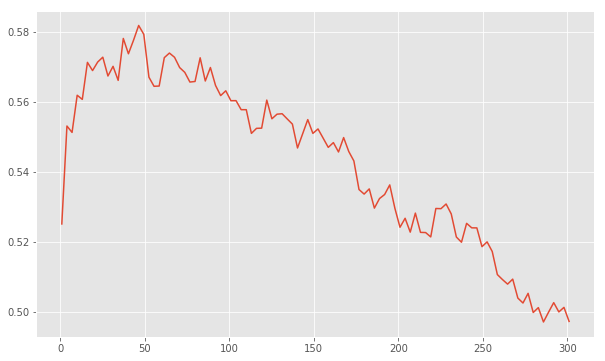

In [113]:
clf.get_params()

Ks = np.linspace(1,301,100)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    clf = KNeighborsClassifier(n_neighbors=int(K))
    scores = cross_val_score(estimator = clf, X = XTrain, y = yTrain.ravel(), cv=10, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

(746,)

In [95]:
decisionTree = tree.DecisionTreeClassifier(max_depth=4)
decisionTree = decisionTree.fit(XTrain, yTrain)

y_pred_train = decisionTree.predict(XTrain)
print('Accuracy on training data= ', metrics.accuracy_score(y_true = yTrain, y_pred = y_pred_train))

y_pred = decisionTree.predict(XTest)
print('Accuracy on test data= ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = yTest, y_pred = y_pred))

print('Accuracy = ', metrics.accuracy_score(y_true = yTest, y_pred = y_pred))

Accuracy on training data=  0.693029490617
Accuracy on test data=  0.649581239531
Confusion Matrix:
[[   0    7    4    0    0]
 [   0  112  131   58   43]
 [   0   40  283  103  134]
 [   0   21   65  272  286]
 [   0    8   25  121 1272]]
Accuracy =  0.649581239531


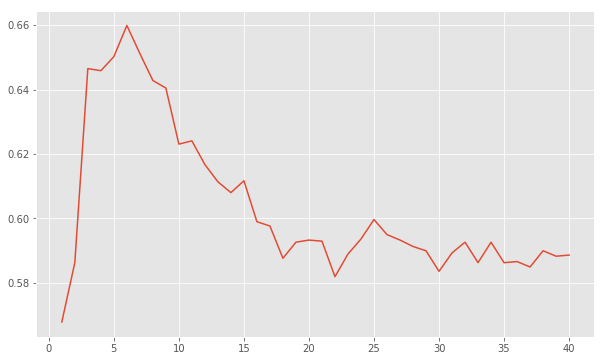

In [85]:
decisionTree.get_params()

Ks = np.linspace(1,40,40)
Accuracies = np.zeros(Ks.shape[0])
for i,K in enumerate(Ks): 
    decisionTree = tree.DecisionTreeClassifier(max_depth=int(K))
    scores = cross_val_score(estimator = decisionTree, X = XTest, y = yTest, cv=5, scoring='accuracy')    
    Accuracies[i]  = scores.mean()
        
plt.plot(Ks,Accuracies)
plt.show()

In [100]:
XTest[1637].shape

(96,)

In [37]:
target.iloc[176]

target    5.0
Name: 176, dtype: float64

In [41]:
predicted[1637]

1.0